<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-3/blob/main/Abalos_Revisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ábalos**

Durante el actual notebook se desarrollarán todos los pasos necesarios para conseguir uniformizar un mapa completo de la localidad de Ábalos a partir de un conjunto de imágenes cartográficas independientes.

## Incorporación de librerías

En primer lugar, incorporamos las librerías necesarias para llevar a cabo el proyecto.

Además, se descargan las imágenes proporcionadas por el Gobierno de La Rioja.

In [1]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=849462315eefd3bef7894d8b275404ed23226c4cc281888dabe7368f0e16382f
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [2]:
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,936 kB/s)
Selecting previously unselect

In [3]:
!wget https://www.dropbox.com/s/2hsbbd0avyonhfs/Abalos.zip?dl=1 -O abalos.zip
!unzip abalos.zip

--2021-05-20 20:45:57--  https://www.dropbox.com/s/2hsbbd0avyonhfs/Abalos.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/2hsbbd0avyonhfs/Abalos.zip [following]
--2021-05-20 20:45:58--  https://www.dropbox.com/s/dl/2hsbbd0avyonhfs/Abalos.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3dc36eeb01a4ed318c9dcfe79f.dl.dropboxusercontent.com/cd/0/get/BO0Hr8W9TfBqTUtjCvq7emfgVzkSr3kDXrY5_x9wPy4xTgPZ5TKb0UJp44q63wfTn6Vj3BiS4lHlMtJ61DgleXEerrLNVsDxpmo3YYOgJYag97KiYSUf3QDKB3bHX-AaOkMO5uGAdXung65yvnkeGffr/file?dl=1# [following]
--2021-05-20 20:45:58--  https://uc3dc36eeb01a4ed318c9dcfe79f.dl.dropboxusercontent.com/cd/0/get/BO0Hr8W9TfBqTUtjCvq7emfgVzkSr3kDXrY5_x9wPy4xTgPZ5TKb0UJp44q63wfTn6Vj3BiS4lHlMtJ61DgleXEerrLNVs

In [4]:
import numpy as np
import imutils
import matplotlib.pyplot as plt
import pytesseract
import os
import cv2
%matplotlib inline

## Definición de funciones

En este apartado se definen todas las funciones implementadas, de las cuales se hará uso durante el desarrollo posterior del proyecto.

Función *mostrarImagen*: Permite la ilustración de cualquier imágen que se pase como parámetro.

In [31]:
def mostrarImagen(image):
    if len(image.shape) == 3:
        img2 = image[:, :, ::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2, cmap = 'gray')
        plt.show()

Función *identificar_leyenda*: Permite la identificación del contorno de la leyenda que identifica la posición de la imágen cartográfica individual respecto al mapa completo.

In [7]:
def identificar_leyenda(leyenda):
    clone = leyenda.copy()
    gray = cv2.cvtColor(leyenda, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 225, 30, cv2.THRESH_OTSU)[1]
    cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  
    for (i, c) in enumerate(cnts):
        area = cv2.contourArea(c)
        if area > 34000 and area < 36000:
            return (i, c)

Función *build_tesseract_options*: Configura las opciones necesarias para la correcta identificación de los números ilustrados en la leyenda de las imágenes. 

In [8]:
def build_tesseract_options(psm = 7):
		# tell Tesseract to only OCR alphanumeric characters
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)
		# set the PSM mode
		options += " --psm {}".format(psm)
		# return the built options string
		return options

Función *sort_contours*: A partir de un conjunto de una lista de contornos, genera una nueva lista con ellos ordenados. 

In [32]:
def sort_contours(cnts):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b:(b[1][1], b[1][0]), reverse = False))
    return cnts

Función *analizaNumero*: Permite la identificación de números representados en una imágen.

In [33]:
def analizaNumero(imagen):
    options = build_tesseract_options(psm = 7)
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 225, 30, cv2.THRESH_OTSU)[1]
    return pytesseract.image_to_string(imagen, config = options)[0]

## Desarrollo del proyecto

Inicialmente, se cargan las imágenes proporcionadas de Ábalos. A su vez, éstas son modificadas haciendo que todas ellas tengan las mismas dimensiones y eliminando los márgenes prescindibles. 
Finalmente, se extrae la leyenda presente en la zona inferior derecha de cada imágen.

In [34]:
# Cargando imágenes de Abalos
abalos = {}
leyendas = {}
for image in os.listdir("Abalos"):
    imagen = cv2.imread("Abalos/" + image)
    imagenRecortada = imagen[300:4190, 741:6752]
    numero = int(image[-6:-4])
    abalos[numero] = imagenRecortada
    
    (i, c) = identificar_leyenda(imagen)
    (a, b, c, d) = cv2.boundingRect(c)
    x = a
    y = b
    finX = a + c
    finY = b + d
    leyenda = imagen[y:finY, x:finX]
    leyendas[numero] = leyenda


Se presenta cada leyenda extraída seguida de la imágen a la cual pertenece.

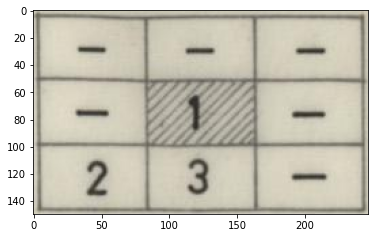

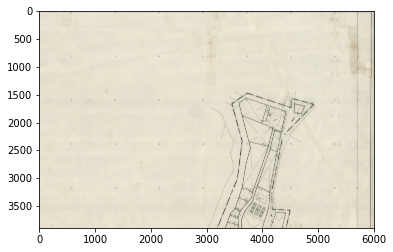

>------------------------------------------------<


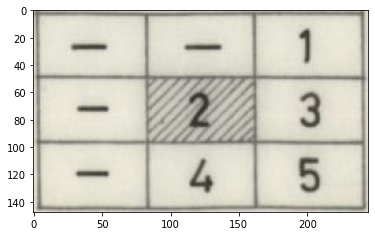

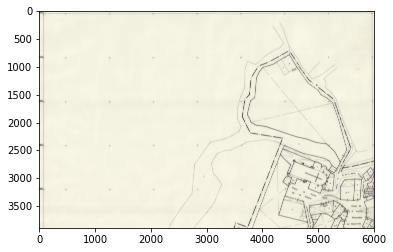

>------------------------------------------------<


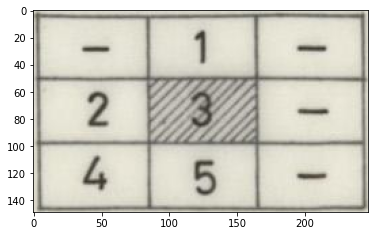

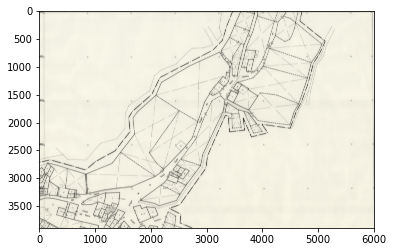

>------------------------------------------------<


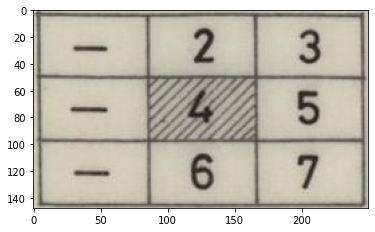

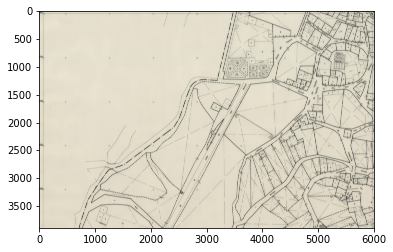

>------------------------------------------------<


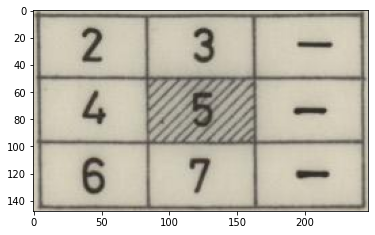

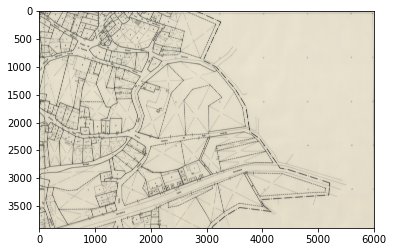

>------------------------------------------------<


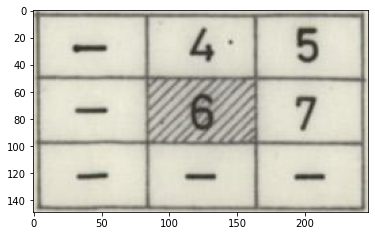

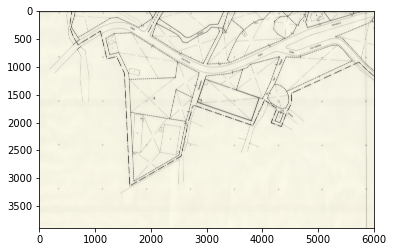

>------------------------------------------------<


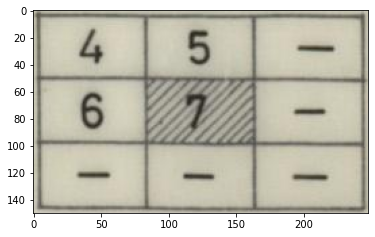

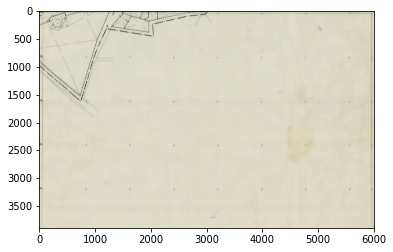

>------------------------------------------------<


In [35]:
for i in range(1, 8):
    mostrarImagen(leyendas[i]) 
    mostrarImagen(abalos[i])
    print('>------------------------------------------------<')

Se adecúan las imágenes para poder aplicarles la identificación de dígitos y contornos.

In [36]:
clone = leyendas[5].copy()
gray = cv2.cvtColor(leyendas[5], cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

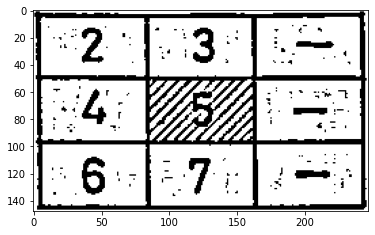

In [37]:
mostrarImagen(thresh)

A continuación, se busca el contorno de cada una de las casillas que conforma la leyenda.

Contorno #56 -- area=3263.00 -- aspectRatio=1.71 -- extent=0.94 -- hullArea = 3308.00


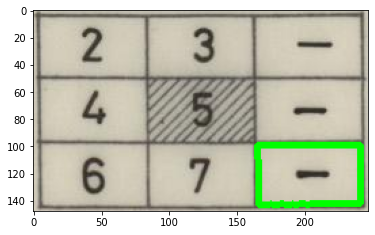

Contorno #57 -- area=3273.50 -- aspectRatio=1.71 -- extent=0.94 -- hullArea = 3313.00


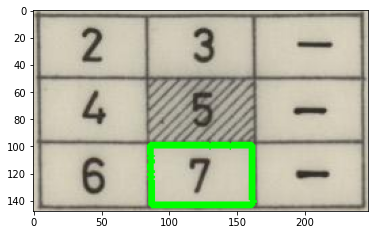

Contorno #58 -- area=3283.50 -- aspectRatio=1.71 -- extent=0.95 -- hullArea = 3341.50


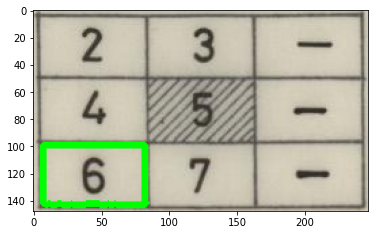

Contorno #126 -- area=3211.00 -- aspectRatio=1.77 -- extent=0.94 -- hullArea = 3276.00


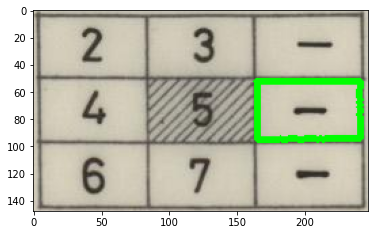

Contorno #134 -- area=3266.50 -- aspectRatio=1.73 -- extent=0.93 -- hullArea = 3345.00


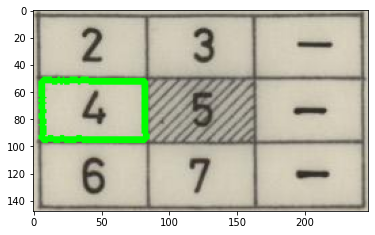

Contorno #191 -- area=3122.00 -- aspectRatio=1.79 -- extent=0.94 -- hullArea = 3162.50


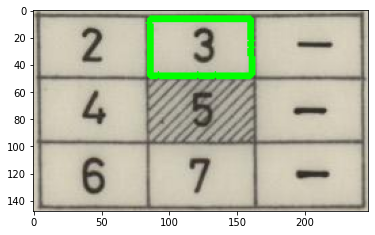

Contorno #192 -- area=3113.00 -- aspectRatio=1.75 -- extent=0.92 -- hullArea = 3230.00


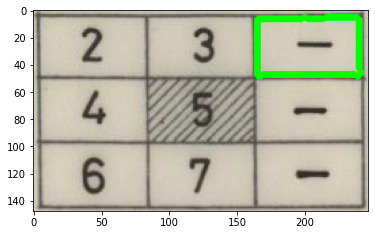

Contorno #193 -- area=3102.50 -- aspectRatio=1.77 -- extent=0.90 -- hullArea = 3228.00


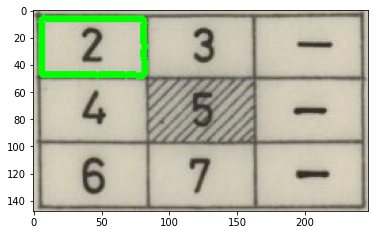

In [15]:
contorno_casillas = []
for (i, c) in enumerate(cnts):
    # Calculamos diversas propiedades
    area = cv2.contourArea(c)
    (x, y, w, h) = cv2.boundingRect(c)
    aspectRatio = w / float(h)
    extent = area / float(w * h)
    hull = cv2.convexHull(c)
    hullArea = cv2.contourArea(hull)

    if area > 3000 and area < 3600:
        contorno_casillas.insert(i, c)
        # Visualizamos cada contorno y el convex hull asociado al mismo
        cv2.drawContours(clone, [c], -1, (240, 0, 159), 3)
        print("Contorno #{} -- area={:.2f} -- aspectRatio={:.2f} -- extent={:.2f} -- hullArea = {:.2f}". format(i + 1, area, aspectRatio, extent, hullArea))
        clone = leyendas[5].copy()
        cv2.drawContours(clone, [c], -1, (0, 255, 0), 3)
        mostrarImagen(clone)

Se continúa ordenando los contornos extraídos en la celda anterior.

In [16]:
contornosOrdenados = sort_contours(contorno_casillas)

In [17]:
boundingBoxesCasillas = [cv2.boundingRect(c) for c in contornosOrdenados]

In [38]:
boundingBoxesCasillas.remove((165, 5, 77, 44))
boundingBoxesCasillas.insert(2, (165, 5, 77, 44))

In [19]:
boundingBoxesCasillas.insert(4, (85, 50, 80, 45))

Una vez obtenida cada casilla de la leyeda y conociendo su orden, es preciso identificar el contenido de cada una de ellas diferenciando entre la presencia de un guión (*-*) o un dígito.

Si se identifica la presencia de un guión, significará que en esa posición no se encuentra ninguna imágen.

In [20]:
vectores = {}
for i in range (1, 8):
    vector=[]
    for (a, b, c, d) in boundingBoxesCasillas:
        x    = a + 3
        y    = b + 3
        finX = a + c - 3
        finY = b + d - 3
        imagen = leyendas[i][y:finY, x:finX]
        #mostrarImagen(imagen)
        vector.append(analizaNumero(imagen))
    vectores[i]=vector

In [21]:
for i in range(1, 8):
    j = 0
    for x in vectores[i]:
        try:
            int(x)
        except:
            vectores[i][j] = "-"
        j = j + 1

    vectores[i][4] = str(i)

In [22]:
for i in range(1, 8):
    print(i, ": " , vectores[i])

1 :  ['-', '-', '-', '-', '1', '-', '2', '3', '-']
2 :  ['-', '-', '1', '-', '2', '3', '-', '4', '5']
3 :  ['-', '1', '-', '2', '3', '-', '4', '5', '-']
4 :  ['-', '2', '3', '-', '4', '-', '-', '6', '7']
5 :  ['2', '3', '-', '4', '5', '-', '6', '7', '-']
6 :  ['-', '4', '5', '-', '6', '7', '-', '-', '-']
7 :  ['4', '5', '-', '6', '7', '-', '-', '-', '-']


Conformándose la cadena final, únicamente falta presentarla en forma de matriz y representar las imágenes soguiendo dicho patrón.

In [23]:
cadenaFinal = []
for i in range(0, vectores[1].index(str(1)) + 1):
    cadenaFinal.append(vectores[1][i])

for i in range(2, 7):
    for x in range(vectores[i].index(str(i - 1)) + 1, vectores[i].index(str(i)) + 1):
        cadenaFinal.append(vectores[i][x])

for i in range(vectores[7].index(str(7)), len(vectores[7])):
    cadenaFinal.append(vectores[7][i])

print(cadenaFinal)

['-', '-', '-', '-', '1', '-', '2', '3', '-', '4', '5', '-', '6', '7', '-', '-', '-', '-']


Utilizando la cadena generada en la celda anterior, se presenta en forma de matriz.

In [24]:
arr = []
for i in range(0, len(cadenaFinal), 3):
    arr.append([cadenaFinal[i], cadenaFinal[i + 1], cadenaFinal[i + 2]])

mat = np.asmatrix(arr)
print(mat)

[['-' '-' '-']
 ['-' '1' '-']
 ['2' '3' '-']
 ['4' '5' '-']
 ['6' '7' '-']
 ['-' '-' '-']]


También se elimina la última columna ya que estaba enteramente representada por guiones. Es decir, no identificaba la posición de ninguna imágen.

In [25]:
mat = mat[1:-1, :-1]
print(mat)

[['-' '1']
 ['2' '3']
 ['4' '5']
 ['6' '7']]


In [26]:
negro = cv2.threshold(abalos[1].copy(), 225, 0, cv2.THRESH_BINARY_INV)[1]

Se conforma finalmente una lista con todas las imágenes concatenadas obedeciendo el orden indicado por la anterior matriz.

In [27]:
fil = mat.shape[0]
col = mat.shape[1]

unidas = []
for i in range(0, fil):
    img = []
    for j in range(0, col):
        try:
            img.append(abalos[int(mat.item(i, j))].copy())
        except:
            img.append(negro.copy())

    unidas.append(cv2.hconcat([img[0], img[1]]))

Presentación de las imágenes originales recortadas, ordenadas y en la posición correcta para conformar el mapa final.

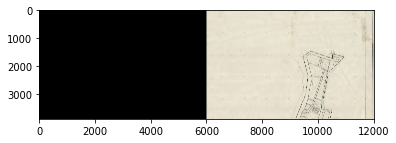

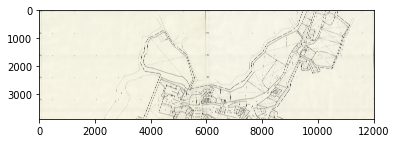

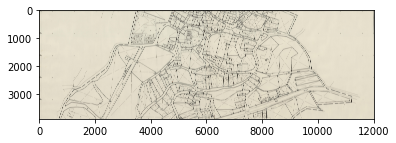

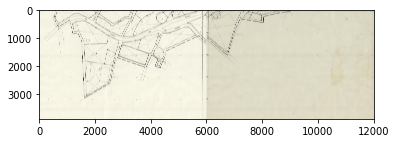

In [28]:
for i in range(0, fil):
    mostrarImagen(unidas[i])

Finalmente, se obtiene la imágen objetivo y se guarda en el directorio de trabajo. 

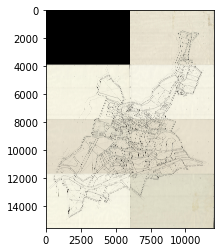

In [29]:
imagen=cv2.vconcat(unidas)
mostrarImagen(imagen)

In [30]:
cv2.imwrite("abalos.jpg", imagen)

True

# **Descomposición gráfica de las fases del proyecto**

Inicialmente, se contaba con un conjunto de 7 imágenes independientes, aparentemente inconexas y desordenadas.

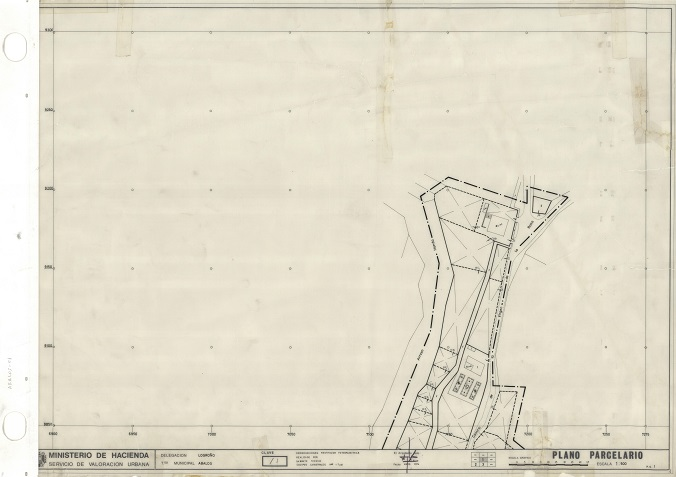

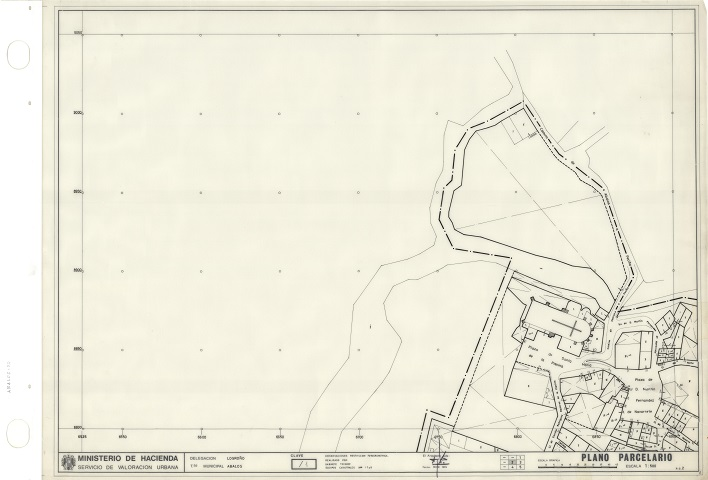

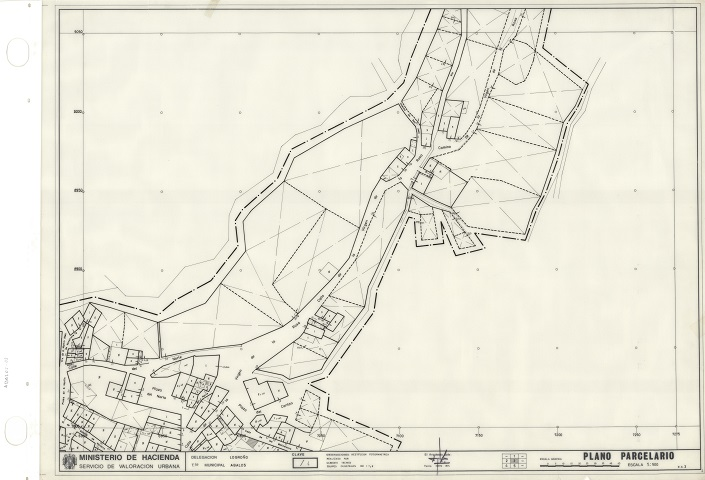

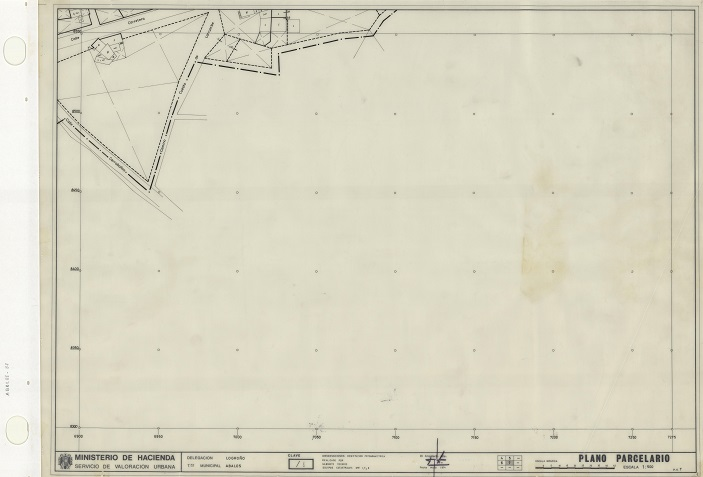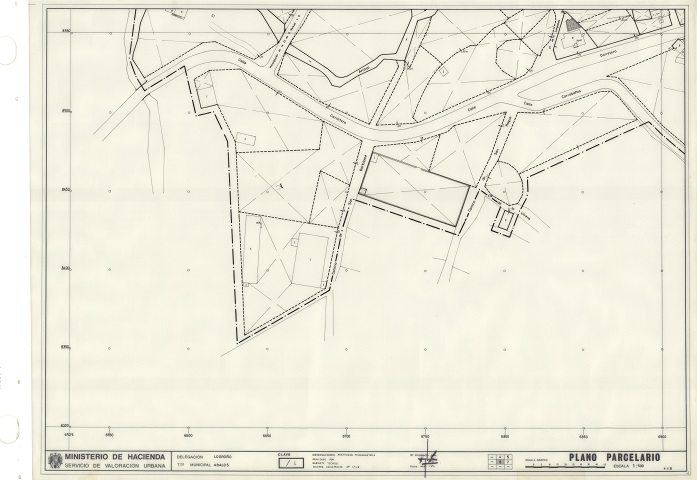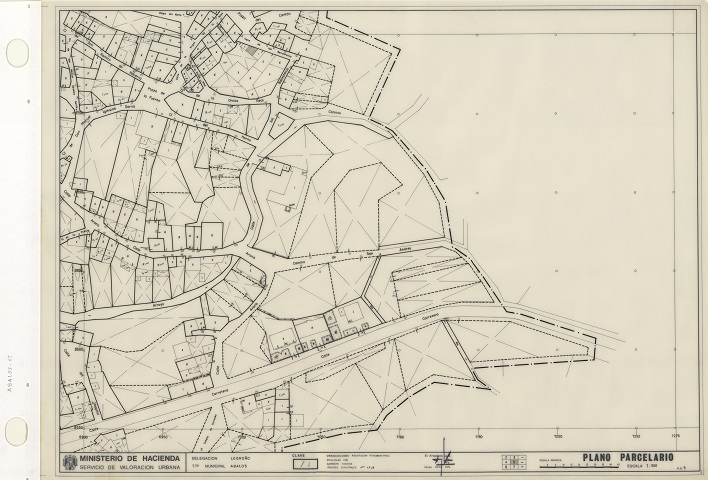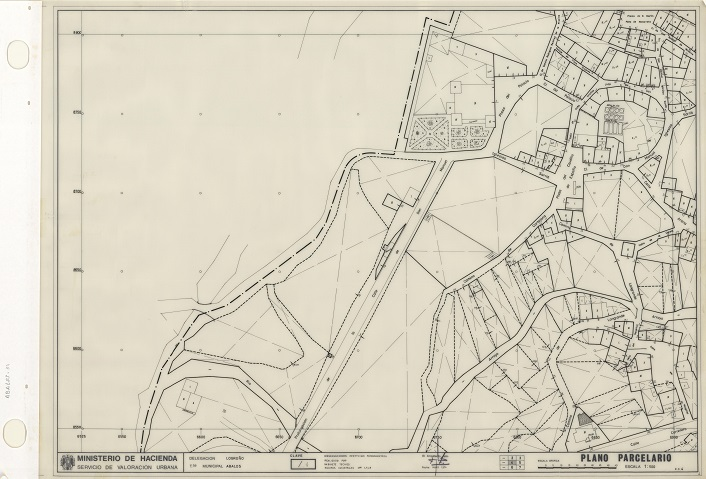

Posteriormente, a través del procedo mostrado anteriormente, se consiguieron aunar todas ellas en una única imágen completa.
No obstante, aun quedaban márgenes a eliminar. 

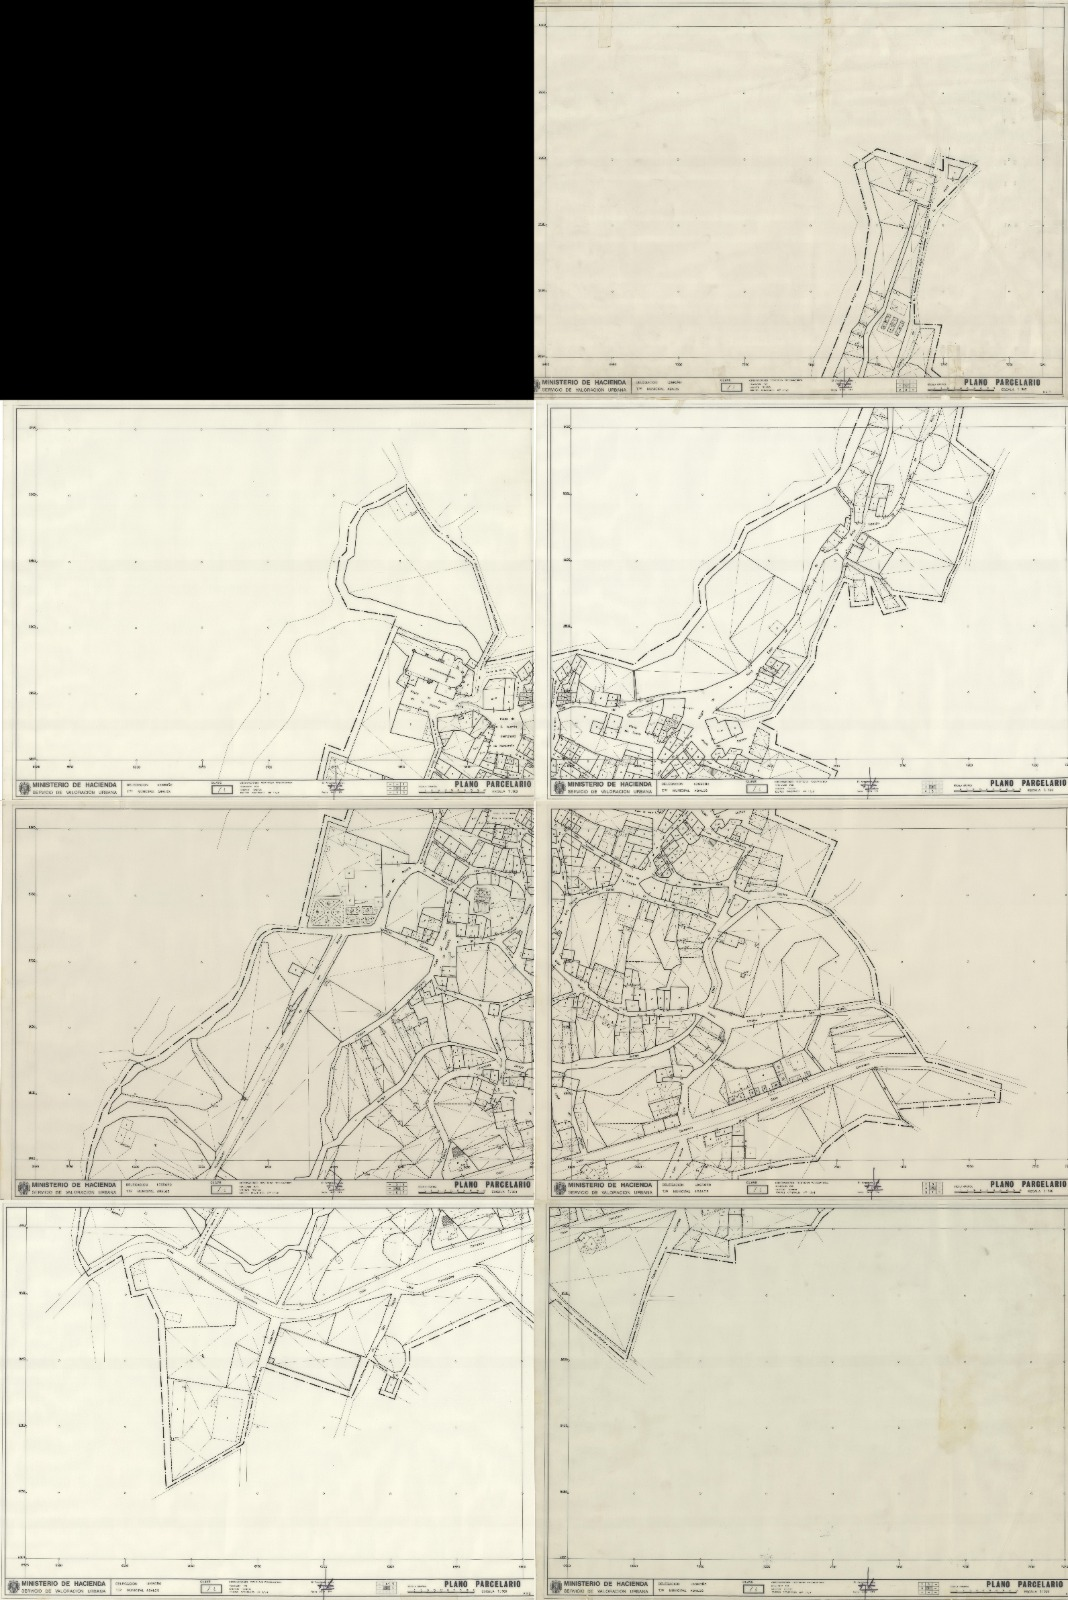

La siguiente fase alcanzada se consiguió con un correcto encuadre horizontal de las imágenes.

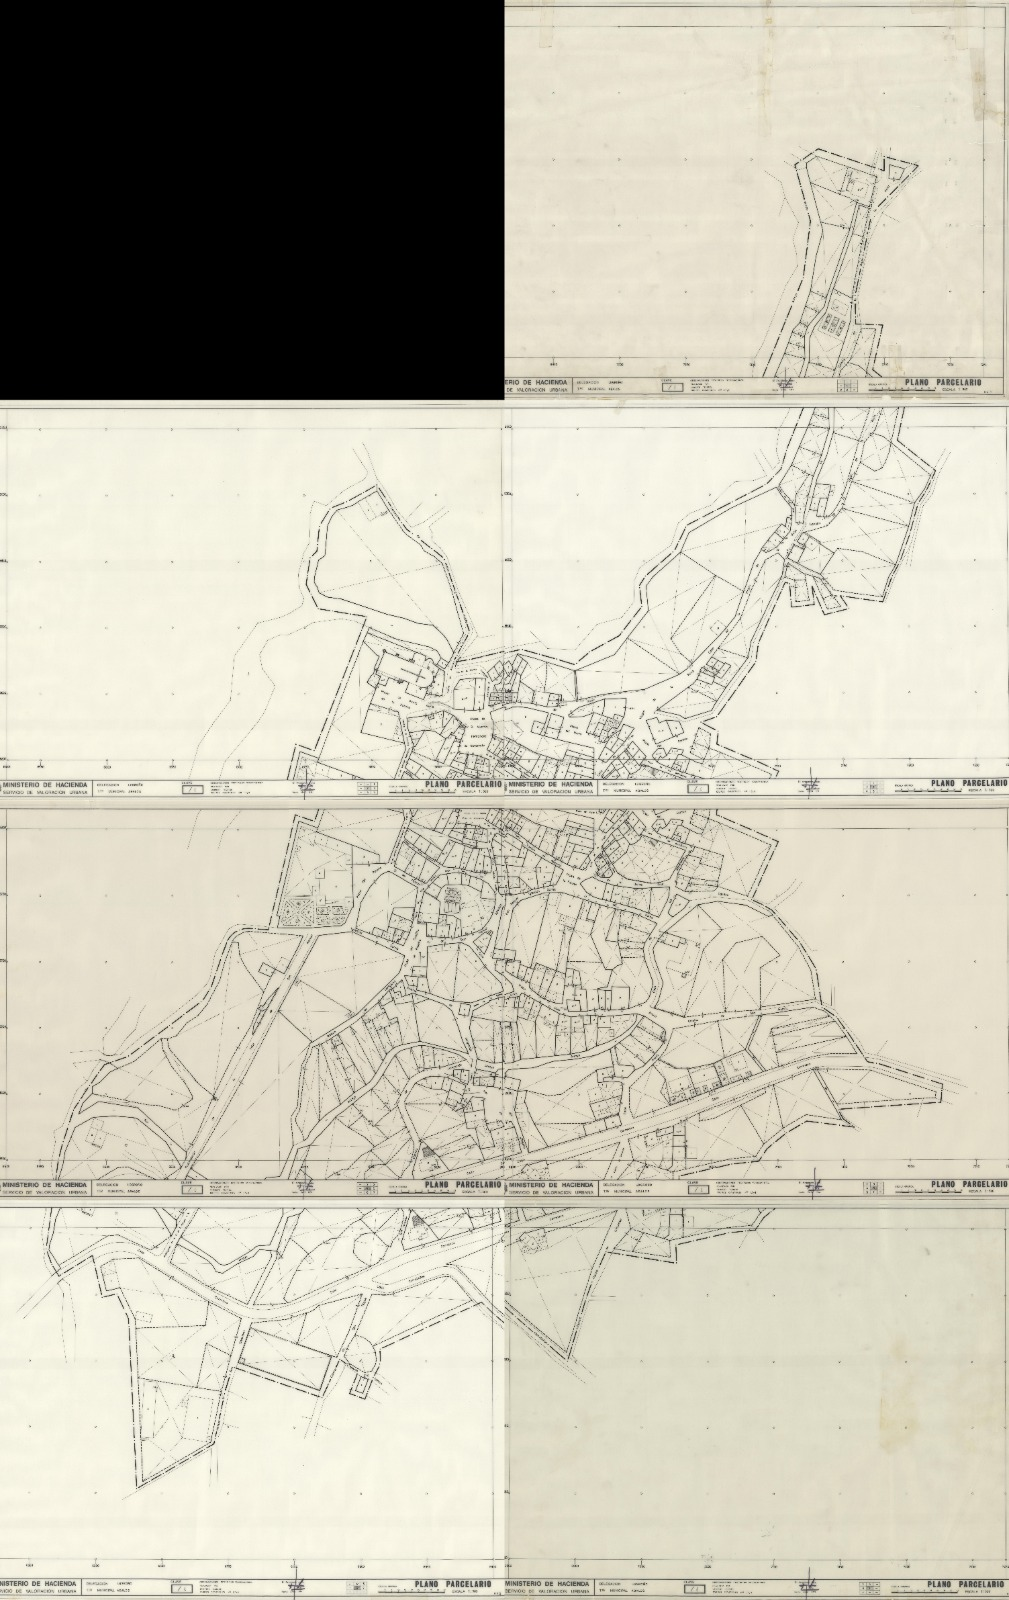

Finalmente, se alcanza la última fase y con ella, la imágen final.

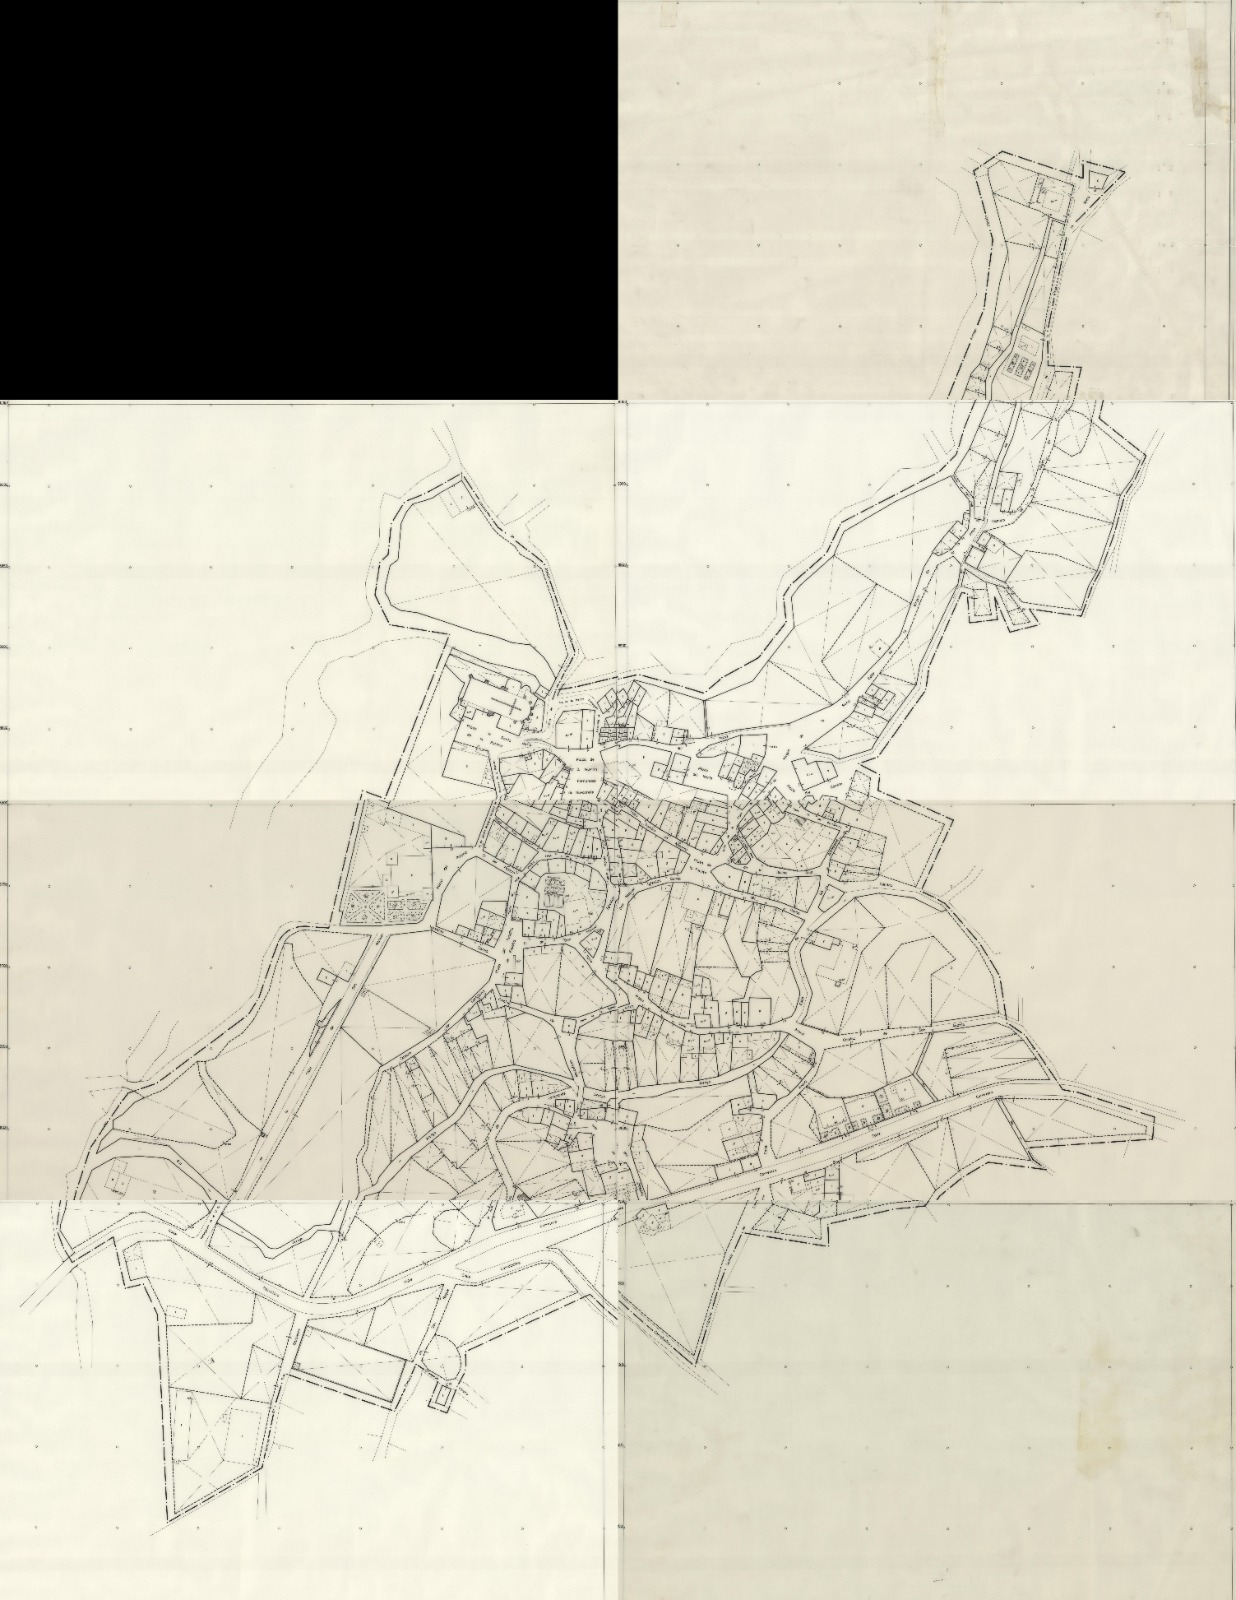